In [5]:
import numpy as np
#from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from keras.utils import load_img, img_to_array
from sklearn.model_selection import train_test_split
import cv2
from matplotlib import pyplot as plt
import os
import tensorflow as tf
import re
import sys
from tqdm import tqdm
from tensorflow import keras

TypeError: Descriptors cannot not be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates

In [ ]:

#import pictures and cut into slices
input_path = "../cse-seminar/inputs/tifBusan.tif"
img = cv2.imread(input_path)
img = cv2.convertScaleAbs(img, alpha = 50,beta = 50)
img = cv2.resize(img,(1530,1530))
plt.imshow(img)


# dimensions of the original image
height, width, _ = img.shape

# Define dimensions for each smaller image
small_width = width // 10
small_height = height // 10

# Slice the original image into smaller images
small_images = []
for row in range(10):
    for col in range(10):
        # starting and ending points of each small image
        start_x = col * small_width
        end_x = (col + 1) * small_width
        start_y = row * small_height
        end_y = (row + 1) * small_height

        # Extract from the original image
        small_image = img[start_y:end_y, start_x:end_x]

        # Append small image to list
        small_images.append(small_image)

# save smaller images
output_path = "../cse-seminar/small_images/"
for i, small_image in enumerate(small_images):
    cv2.imwrite( '../cse-seminar/small_images/small_image%d.png' % i, small_image)


In [3]:

# Set input shape
input_shape = (153, 153, 3)  # Assuming RGB images of size 320x320

# Build CNN model
model = Sequential()

# convolutional layers
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))


# Flatten output from previous layer
model.add(Flatten())

# fully connected layer
model.add(Dense(128, activation='relu'))

# Output layer
model.add(Dense(input_shape[0] * input_shape[1], activation='sigmoid'))  # Output mask with pixel-wise binary classification

# Reshape output to match input shape
model.add(tf.keras.layers.Reshape((input_shape[0], input_shape[1], 1)))

NameError: name 'Sequential' is not defined

In [4]:
# Add Metrics
def iou(y_true, y_pred):
    intersection = tf.reduce_sum(tf.multiply(y_true, y_pred))
    union = tf.reduce_sum(tf.subtract(tf.add(y_true, y_pred), tf.multiply(y_true, y_pred)))
    iou_score = tf.divide(intersection, union)
    return iou_score


In [113]:

# Compile
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[iou]) #write new metric

In [114]:

# Load dataset and preprocess

folder_path = '../cse-seminar/small_images/'

# Initialize empty list to store image input paths
image_paths = []

# Iterate over files
for filename in os.listdir(folder_path):
    # Check if the file has a common image extension (e.g., jpg, png, etc.)
    if filename.lower().endswith('.png'):
        # Construct the full file path by joining the folder path and filename
        file_path = os.path.join(folder_path, filename)
        # Append the file path to the list of image paths
        image_paths.append(file_path)

image_path = []
for root, dirs, files in os.walk('../cse-seminar/small_images_withlabel'):
    # iterate over 1000 images
    for file in files:
        # create path
        path = os.path.join(root,file)
        # add path to list
        image_path.append(path)

images = []
testimg = []

for path in image_paths:
    img = load_img(path, target_size=input_shape[:2])
    img_array = img_to_array(img)
    images.append(img_array)

for path in image_path:
    file = tf.io.read_file(path)
    img = tf.image.decode_png(file, channels=3, dtype=tf.uint8)
    testimg.append(img)

X = np.array(images)  # Convert into a numpy array
len(image_path)

68

In [1]:

labels = np.zeros((X.shape[0],) + input_shape[:2], dtype=np.uint8)


labeled_data_path = '../cse-seminar/labeled_data/'
labeled_data = []

for filename in os.listdir(labeled_data_path):
    # Check if the file has a common image extension (e.g., jpg, png, etc.)
    if filename.lower().endswith('.npy'):
        # Construct the full file path by joining the folder path and filename
        file_path = os.path.join(labeled_data_path, filename)
        # Append the file path to the list of image paths
        labeled_data.append(file_path)

pattern = r"task-(\d+)-"
for i in range(0,len(labeled_data) - 1):
    match = re.search(pattern, labeled_data[i])
    result = int(re.sub(r"task-|-", "", match.group(0)),10)
    labels[result - 1] = np.load(labeled_data[i])

# a list to collect paths of 1000 masks
mask_path = []
for root, dirs, files in os.walk('../cse-seminar/labeled_data'):
    #iterate over 1000 masks
    for file in files:
        # obtain the path
        path = os.path.join(root,file)
        # add path to the list
        mask_path.append(path)

# create a list to store masks
testmasks = []
# iterate over 1000 mask paths
for path in tqdm(mask_path):
    # read the file
    mask = np.load(path)
    # add channel
    mask = mask[..., tf.newaxis]
    # append mask to the list
    testmasks.append(mask)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(testmasks[5])
ax2.imshow(testimg[5])

NameError: name 'np' is not defined

In [116]:
# Split data into train and test
def normalize_image(input_image):
    input_image = tf.cast(input_image, tf.float32)
    input_image = input_image/ 255.0
    input_image = tf.image.resize(input_image, (128,128))
    return input_image

def normalize_mask(input_mask):
    input_mask = input_mask/ 255.0
    input_mask = tf.image.resize(input_mask, (128,128))
    input_mask = tf.cast(input_mask, tf.uint8)
    return input_mask

testimg = [normalize_image(i) for i in testimg]
testmasks =  [normalize_mask(m) for m in testmasks]

X_train, X_test, y_train, y_test = train_test_split(testimg, testmasks, test_size=0.2, random_state=42)

X_train = tf.data.Dataset.from_tensor_slices(X_train)
X_test = tf.data.Dataset.from_tensor_slices(X_test)

y_train = tf.data.Dataset.from_tensor_slices(y_train)
y_test = tf.data.Dataset.from_tensor_slices(y_test)

X_train.element_spec, y_train.element_spec, X_test.element_spec, y_test.element_spec

(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None),
 TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None))

In [117]:
# zip images and masks
train = tf.data.Dataset.zip((X_train, y_train))
val = tf.data.Dataset.zip((X_test, y_test))

In [118]:
BATCH = 5
AT = tf.data.AUTOTUNE
BUFFER = 10

STEPS_PER_EPOCH = 54 //BATCH
VALIDATION_STEPS = 14 //BATCH

train = train.cache().shuffle(BUFFER).batch(BATCH).repeat()
train = train.prefetch(buffer_size=AT)
val = val.batch(BATCH)

In [119]:
# Use pre-trained DenseNet121 without head
base = keras.applications.DenseNet121(input_shape=[128,128,3],
                                      include_top=False,
                                      weights='imagenet',
                                      )

In [120]:
len(base.layers)

427

In [121]:
#final ReLU activation layer for each feature map size, i.e. 4, 8, 16, 32, and 64, required for skip-connections
skip_names = ['conv1/relu', # size 64*64
             'pool2_relu',  # size 32*32
             'pool3_relu',  # size 16*16
             'pool4_relu',  # size 8*8
             'relu'        # size 4*4
             ]

In [122]:
#output of these layers
skip_outputs = [base.get_layer(name).output for name in skip_names]
for i in range(len(skip_outputs)):
    print(skip_outputs[i])

KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 64), dtype=tf.float32, name=None), name='conv1/relu/Relu:0', description="created by layer 'conv1/relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 256), dtype=tf.float32, name=None), name='pool2_relu/Relu:0', description="created by layer 'pool2_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 512), dtype=tf.float32, name=None), name='pool3_relu/Relu:0', description="created by layer 'pool3_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 8, 8, 1024), dtype=tf.float32, name=None), name='pool4_relu/Relu:0', description="created by layer 'pool4_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 4, 4, 1024), dtype=tf.float32, name=None), name='relu/Relu:0', description="created by layer 'relu'")


In [123]:
#Building the downstack with the above layers. We use the pre-trained model as such, without any fine-tuning.
downstack = keras.Model(inputs=base.input,
                       outputs=skip_outputs)
# freeze the downstack layers
downstack.trainable = False

In [124]:
!pip install -q git+https://github.com/tensorflow/examples.git --quiet

In [125]:
from tensorflow_examples.models.pix2pix import pix2pix
# Four upstack layers for upsampling sizes
# 4->8, 8->16, 16->32, 32->64
upstack = [pix2pix.upsample(512,3),
          pix2pix.upsample(256,3),
          pix2pix.upsample(128,3),
          pix2pix.upsample(64,3)]

In [126]:
upstack[1].layers

In [127]:
# define the input layer
inputs = keras.layers.Input(shape=[128,128,3])

# downsample
down = downstack(inputs)
out = down[-1]

# prepare skip-connections
skips = reversed(down[:-1])
# choose the last layer at first 4 --> 8

# upsample with skip-connections
for up, skip in zip(upstack,skips):
    out = up(out)
    out = keras.layers.Concatenate()([out,skip])

# define the final transpose conv layer
# image 128 by 128 with 59 classes
out = keras.layers.Conv2DTranspose(2, 3,
                                  strides=2,
                                  padding='same',
                                  )(out)
# complete unet model
unet = keras.Model(inputs=inputs, outputs=out)

(<tf.Tensor: shape=(5, 128, 128, 3), dtype=float32, numpy=
array([[[[0.20644544, 0.30914786, 0.30914786],
         [0.19944434, 0.19944434, 0.19944434],
         [0.2077544 , 0.21317725, 0.26875216],
         ...,
         [0.38991293, 0.39215687, 0.39215687],
         [0.39215687, 0.3970307 , 0.3970307 ],
         [0.49209478, 0.4352933 , 0.39697686]],

        [[0.32297054, 0.37300858, 0.37300858],
         [0.23727717, 0.23761375, 0.23761375],
         [0.37171638, 0.42278543, 0.4498623 ],
         ...,
         [0.37142286, 0.39215687, 0.4027393 ],
         [0.40677837, 0.45181262, 0.46761894],
         [0.43663967, 0.46981406, 0.4711604 ]],

        [[0.37300858, 0.37861842, 0.37880543],
         [0.2709138 , 0.31211704, 0.33030042],
         [0.57482105, 0.6234942 , 0.65288985],
         ...,
         [0.38431802, 0.4097942 , 0.46862423],
         [0.4339419 , 0.5016809 , 0.5779528 ],
         [0.43348017, 0.5299897 , 0.62013924]],

        ...,

        [[0.39215687, 0.569087  ,

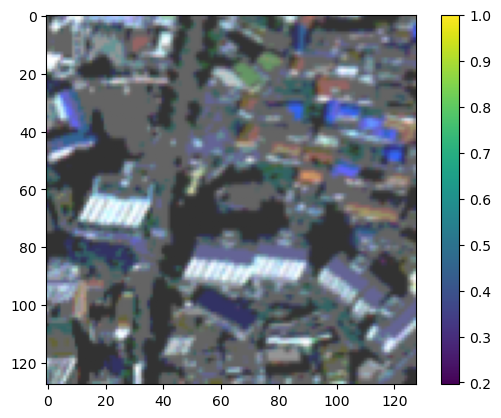

In [128]:
#checking for model and data compatibility
# infer on train dataset
example = next(iter(train))
preds = unet(example[0])
print(example)
# visualize an image
plt.imshow(example[0][0])
plt.colorbar()
plt.show()

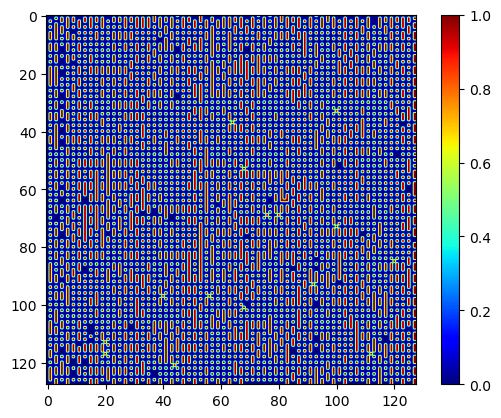

In [129]:
pred_mask = tf.argmax(preds, axis=-1)
pred_mask = tf.expand_dims(pred_mask, -1)
plt.imshow(pred_mask[0], cmap='jet')
plt.colorbar()

In [130]:
# compiling the model
def Compile_Model():
    unet.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy'])
Compile_Model()

In [131]:
#training and fine-tuning
hist_1 = unet.fit(train,
               validation_data=val,
               steps_per_epoch=STEPS_PER_EPOCH,
               validation_steps=VALIDATION_STEPS,
               epochs=20,
               verbose=2)

Epoch 1/20
10/10 - 15s - loss: 0.4621 - accuracy: 0.8252 - val_loss: 0.5283 - val_accuracy: 0.8416 - 15s/epoch - 2s/step
Epoch 2/20
10/10 - 5s - loss: 0.3641 - accuracy: 0.8845 - val_loss: 0.4806 - val_accuracy: 0.8416 - 5s/epoch - 480ms/step
Epoch 3/20
10/10 - 5s - loss: 0.3289 - accuracy: 0.8850 - val_loss: 0.4521 - val_accuracy: 0.8416 - 5s/epoch - 484ms/step
Epoch 4/20
10/10 - 5s - loss: 0.3002 - accuracy: 0.8853 - val_loss: 0.5122 - val_accuracy: 0.8416 - 5s/epoch - 483ms/step
Epoch 5/20
10/10 - 5s - loss: 0.2745 - accuracy: 0.8830 - val_loss: 0.4994 - val_accuracy: 0.8416 - 5s/epoch - 480ms/step
Epoch 6/20
10/10 - 5s - loss: 0.2596 - accuracy: 0.8865 - val_loss: 0.4816 - val_accuracy: 0.8416 - 5s/epoch - 477ms/step
Epoch 7/20
10/10 - 5s - loss: 0.2458 - accuracy: 0.8872 - val_loss: 0.5545 - val_accuracy: 0.8416 - 5s/epoch - 478ms/step
Epoch 8/20
10/10 - 5s - loss: 0.2416 - accuracy: 0.8920 - val_loss: 0.7524 - val_accuracy: 0.8376 - 5s/epoch - 477ms/step
Epoch 9/20
10/10 - 5s - l

1/1 [==============================] - 4s 4s/step


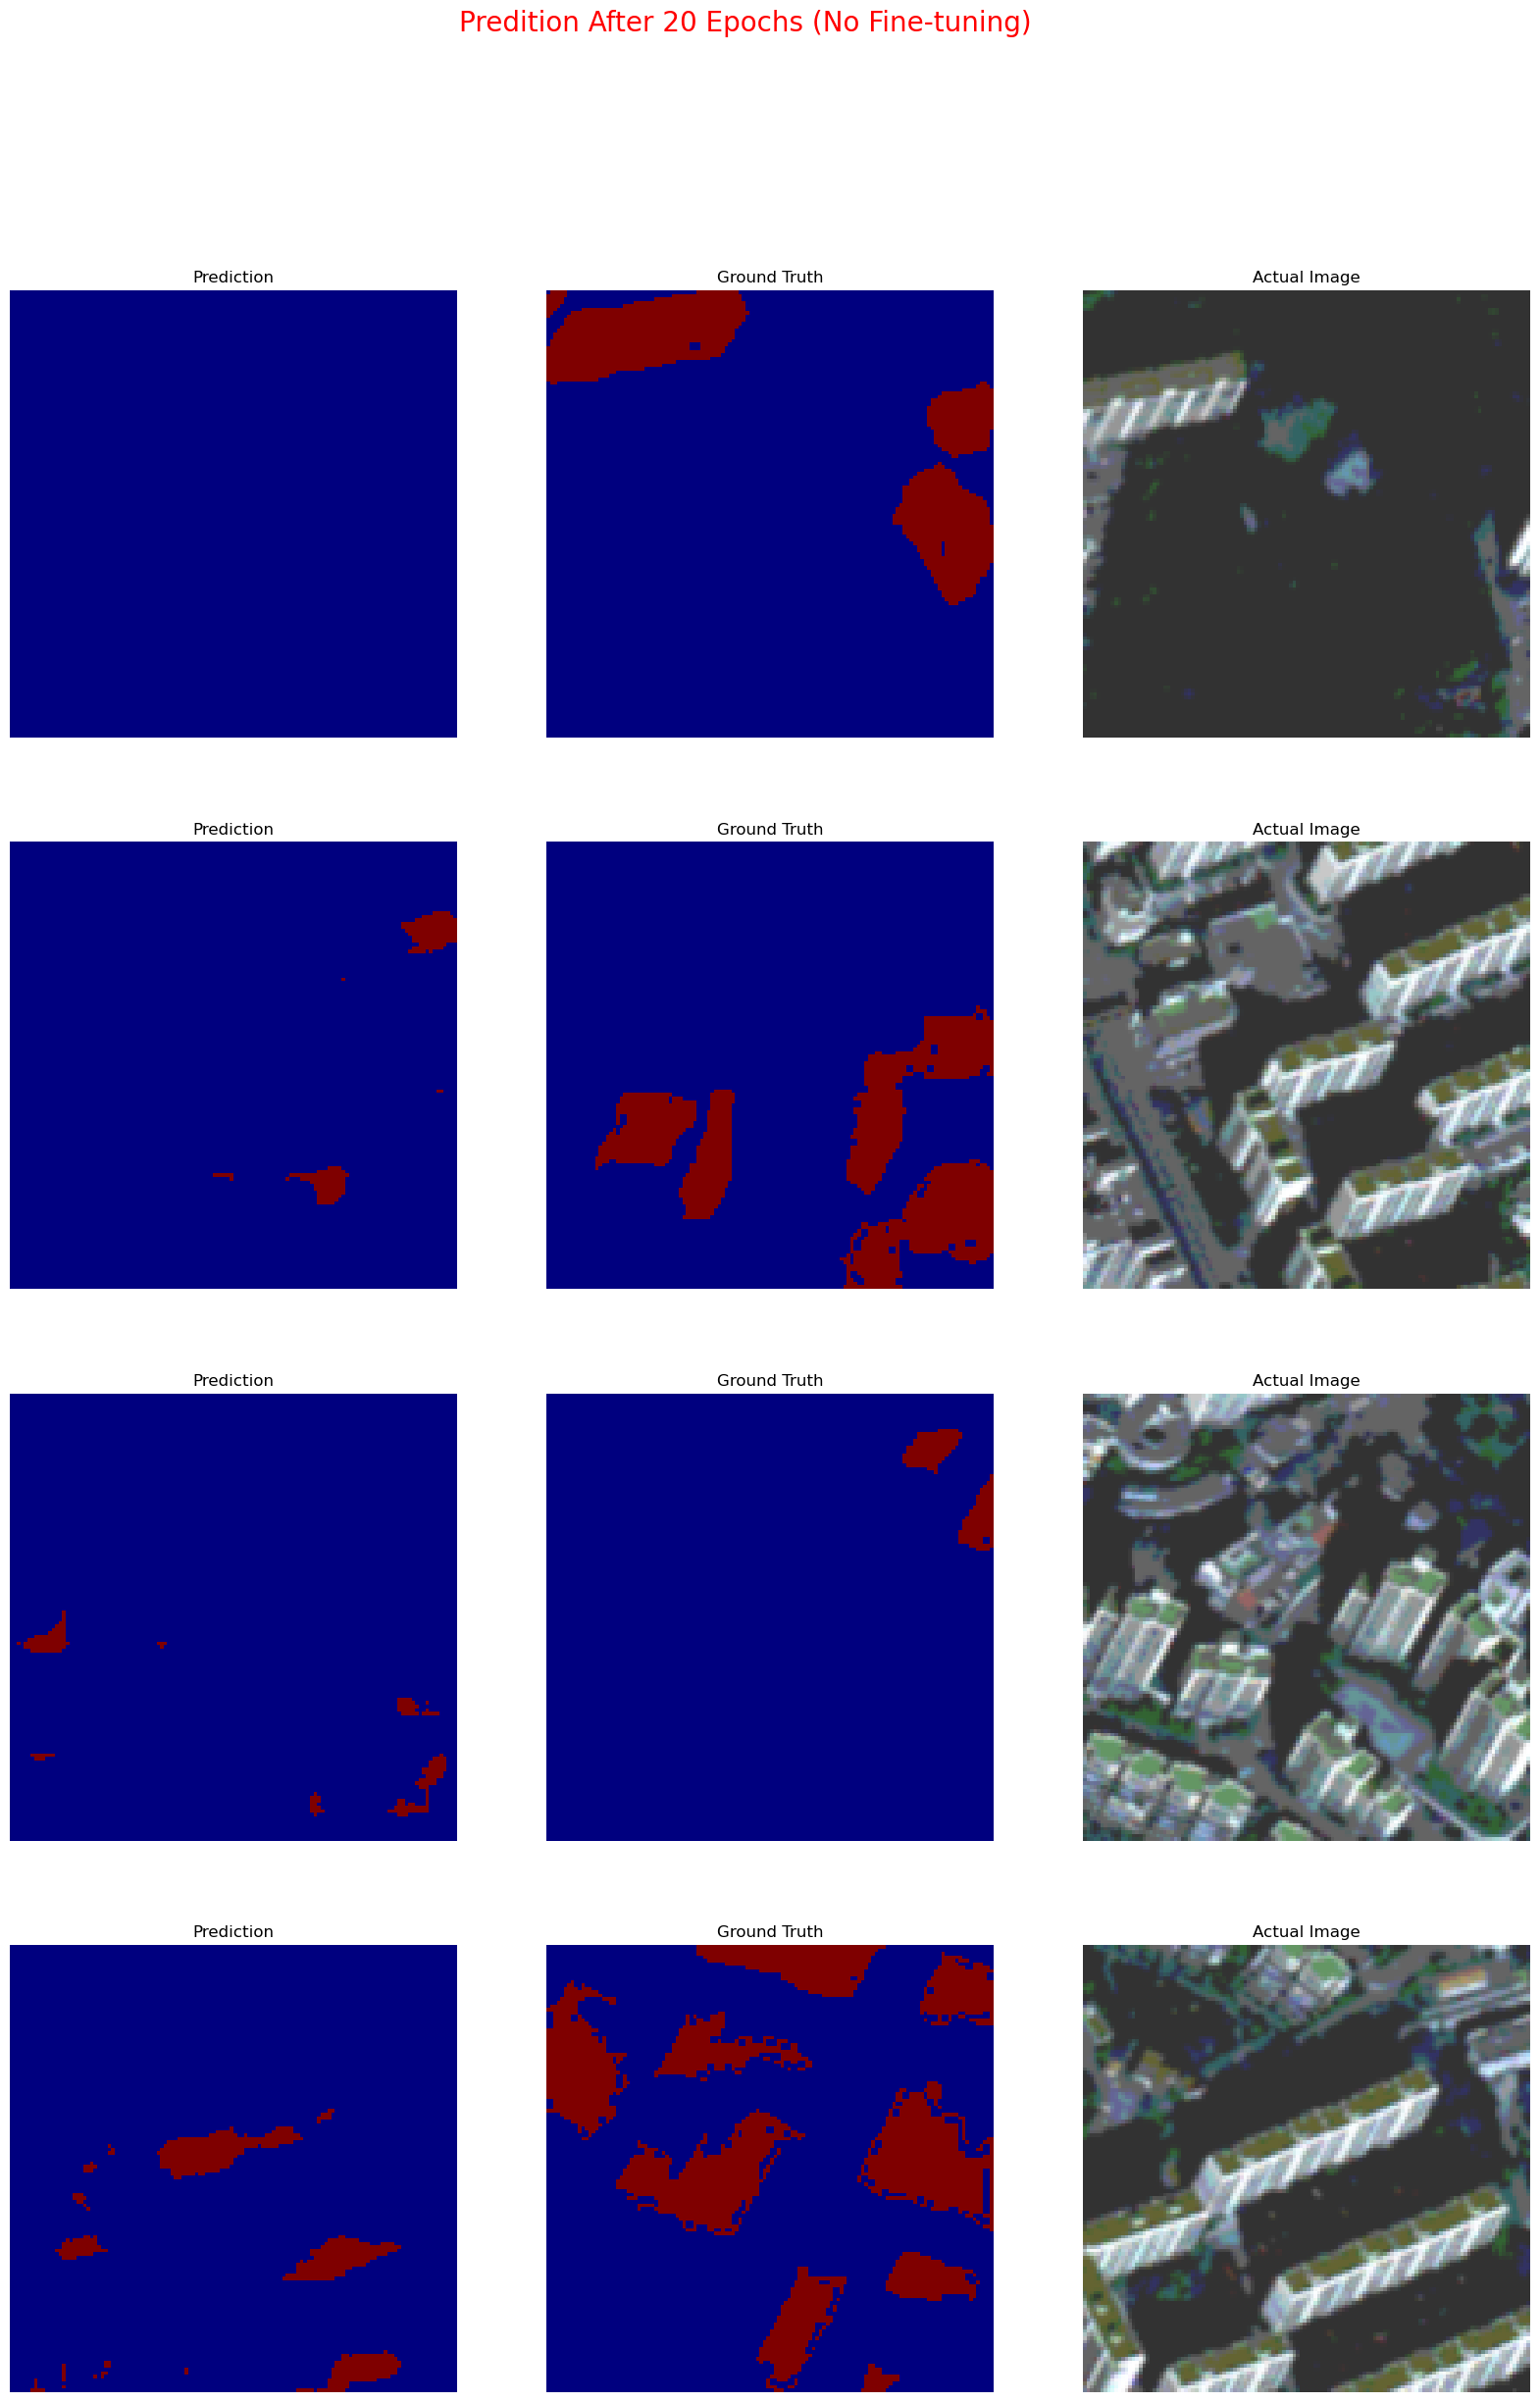

In [132]:
# select a validation data batch
img, mask = next(iter(val))
# make prediction
pred = unet.predict(img)
plt.figure(figsize=(20,28))

k = 0
for i in pred:
    # plot the predicted mask
    plt.subplot(4,3,1+k*3)
    i = tf.argmax(i, axis=-1)
    plt.imshow(i,cmap='jet')
    plt.axis('off')
    plt.title('Prediction')

    # plot the groundtruth mask
    plt.subplot(4,3,2+k*3)
    plt.imshow(mask[k], cmap='jet')
    plt.axis('off')
    plt.title('Ground Truth')

    # plot the actual image
    plt.subplot(4,3,3+k*3)
    plt.imshow(img[k])
    plt.axis('off')
    plt.title('Actual Image')
    k += 1
    if k == 4: break
plt.suptitle('Predition After 20 Epochs (No Fine-tuning)', color='red', size=20)
plt.show()

In [ ]:

# predictions


predictions = model.predict(X_test)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(predictions[0],cmap='gray')
ax2.imshow(X_test[0], cmap='gray')


# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(predictions[0])